1. Dataset - BankChurners


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [29]:
df = pd.read_csv("C:/Users/MadhavaRaj/Desktop/churn_prediction/data/churn-bigml-80.csv")

# Display the first few rows of the dataset
print(df.head())

  state  account length  area code international plan voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   number vmail messages  total day minutes  total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   total day charge  total eve minutes  total eve calls  total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47   

In [30]:
le = LabelEncoder()

# Encoding 'state', 'international plan', and 'voice mail plan' as these are categorical
df['state'] = le.fit_transform(df['state'])
df['international plan'] = le.fit_transform(df['international plan'])
df['voice mail plan'] = le.fit_transform(df['voice mail plan'])

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2666 non-null   int32  
 1   account length          2666 non-null   int64  
 2   area code               2666 non-null   int64  
 3   international plan      2666 non-null   int32  
 4   voice mail plan         2666 non-null   int32  
 5   number vmail messages   2666 non-null   int64  
 6   total day minutes       2666 non-null   float64
 7   total day calls         2666 non-null   int64  
 8   total day charge        2666 non-null   float64
 9   total eve minutes       2666 non-null   float64
 10  total eve calls         2666 non-null   int64  
 11  total eve charge        2666 non-null   float64
 12  total night minutes     2666 non-null   float64
 13  total night calls       2666 non-null   int64  
 14  total night charge 

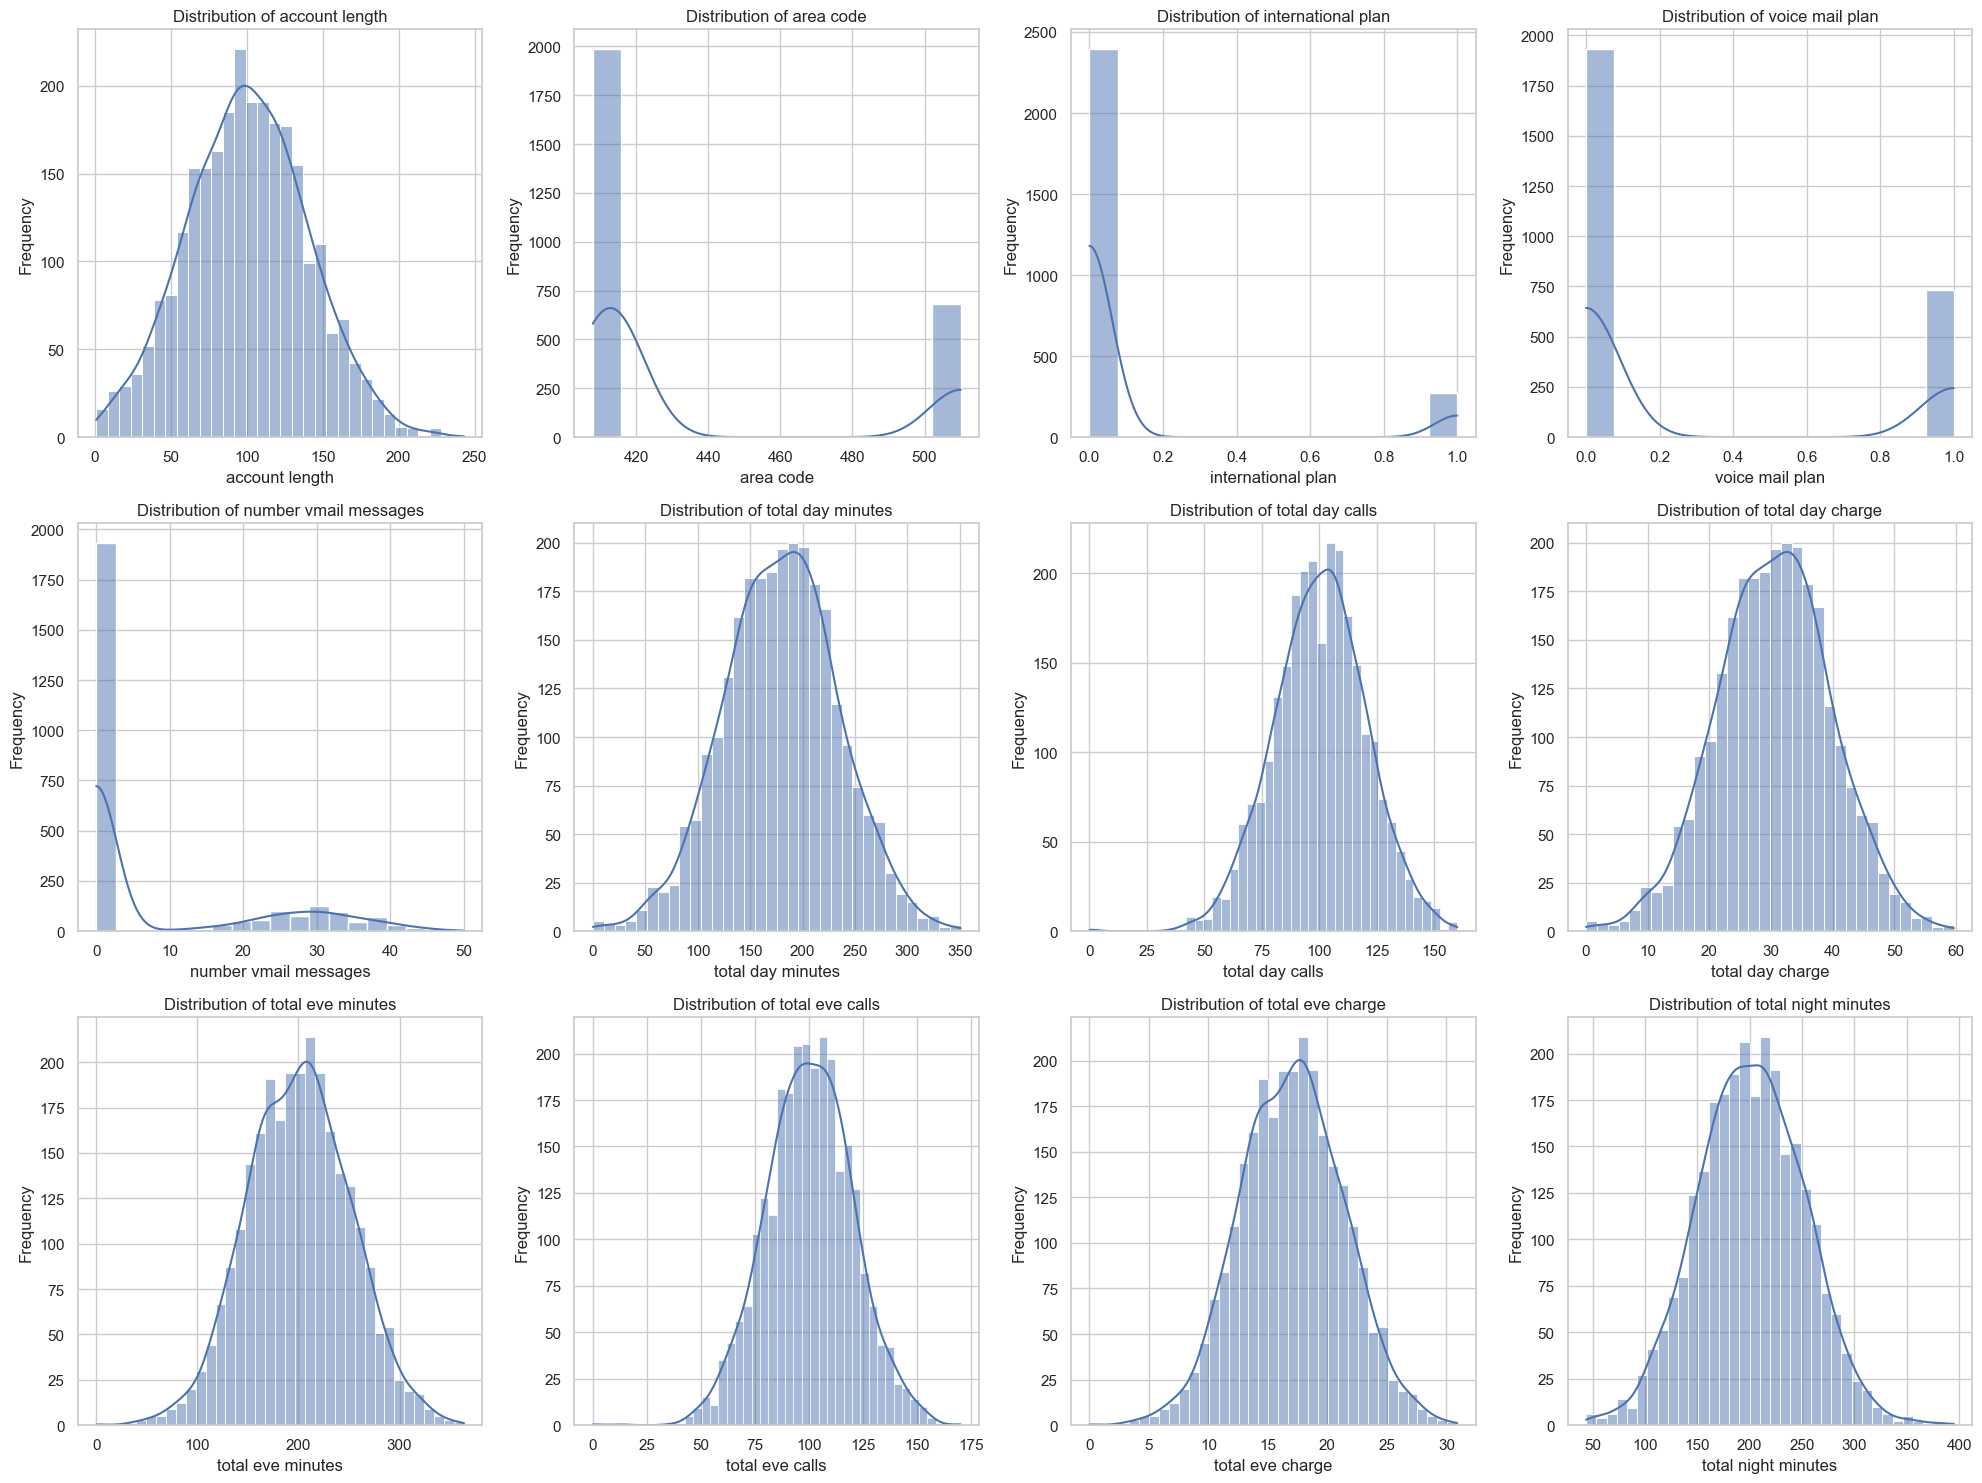

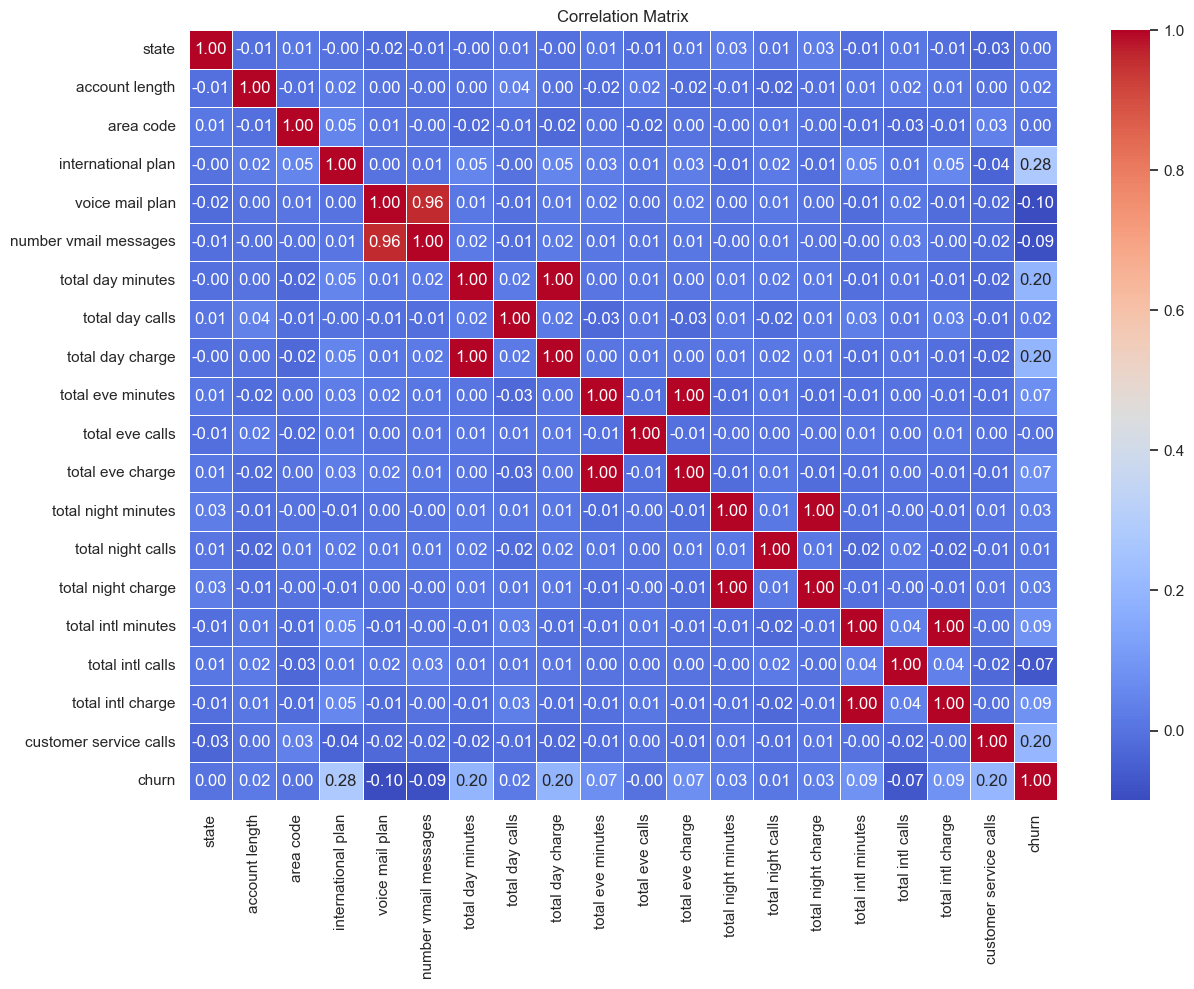

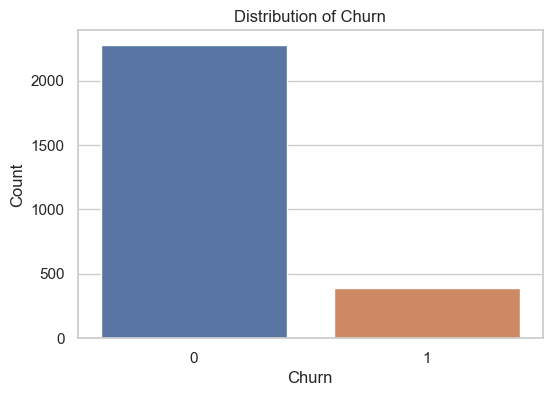

In [31]:
print("Dataset Information:")
df.info()

# Summary statistics of the dataset
print("\nSummary Statistics:")
print(df.describe())

# Plotting distributions of numerical features
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

for ax, column in zip(axes.flatten(), df.columns[1:-1]):
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Correlation matrix to check relationships between features and target
correlation = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Distribution of churn
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df)
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [32]:
# Separating features and target
X = df.drop('churn', axis=1)
y = df['churn']

Accuracy: 0.951310861423221
Confusion Matrix: 
[[455   0]
 [ 26  53]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       455
           1       1.00      0.67      0.80        79

    accuracy                           0.95       534
   macro avg       0.97      0.84      0.89       534
weighted avg       0.95      0.95      0.95       534

AUC Score: 0.910460425650299


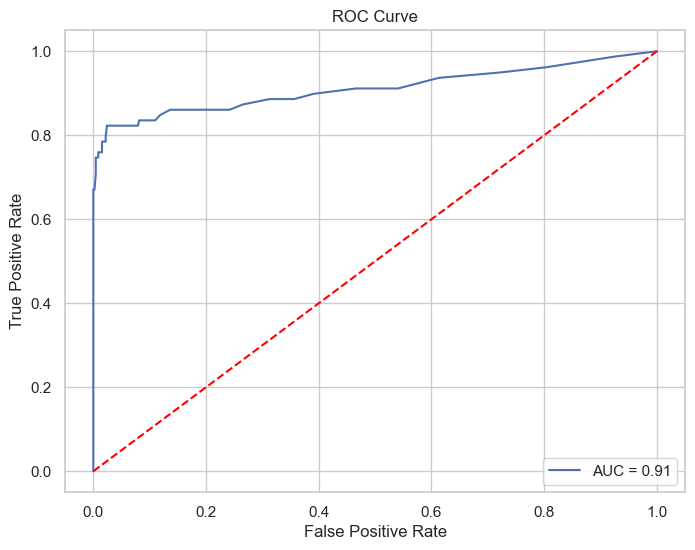

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Making predictions
y_pred = rf.predict(X_test)

# Existing evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the previous evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Classification Report: \n{class_report}")

# Now adding AUC-ROC evaluation

# 1. Get predicted probabilities for the positive class (churn = 1)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 2. Calculate AUC score
from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc}")

# 3. Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [42]:
# Install LIME if needed
# !pip install lime
instance_index = 0
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['No Churn', 'Churn'], mode='classification')

# Explain a single instance prediction
exp = lime_explainer.explain_instance(X_test.values[instance_index], rf.predict_proba)
exp.show_in_notebook(show_table=True)


C:\Users\MadhavaRaj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


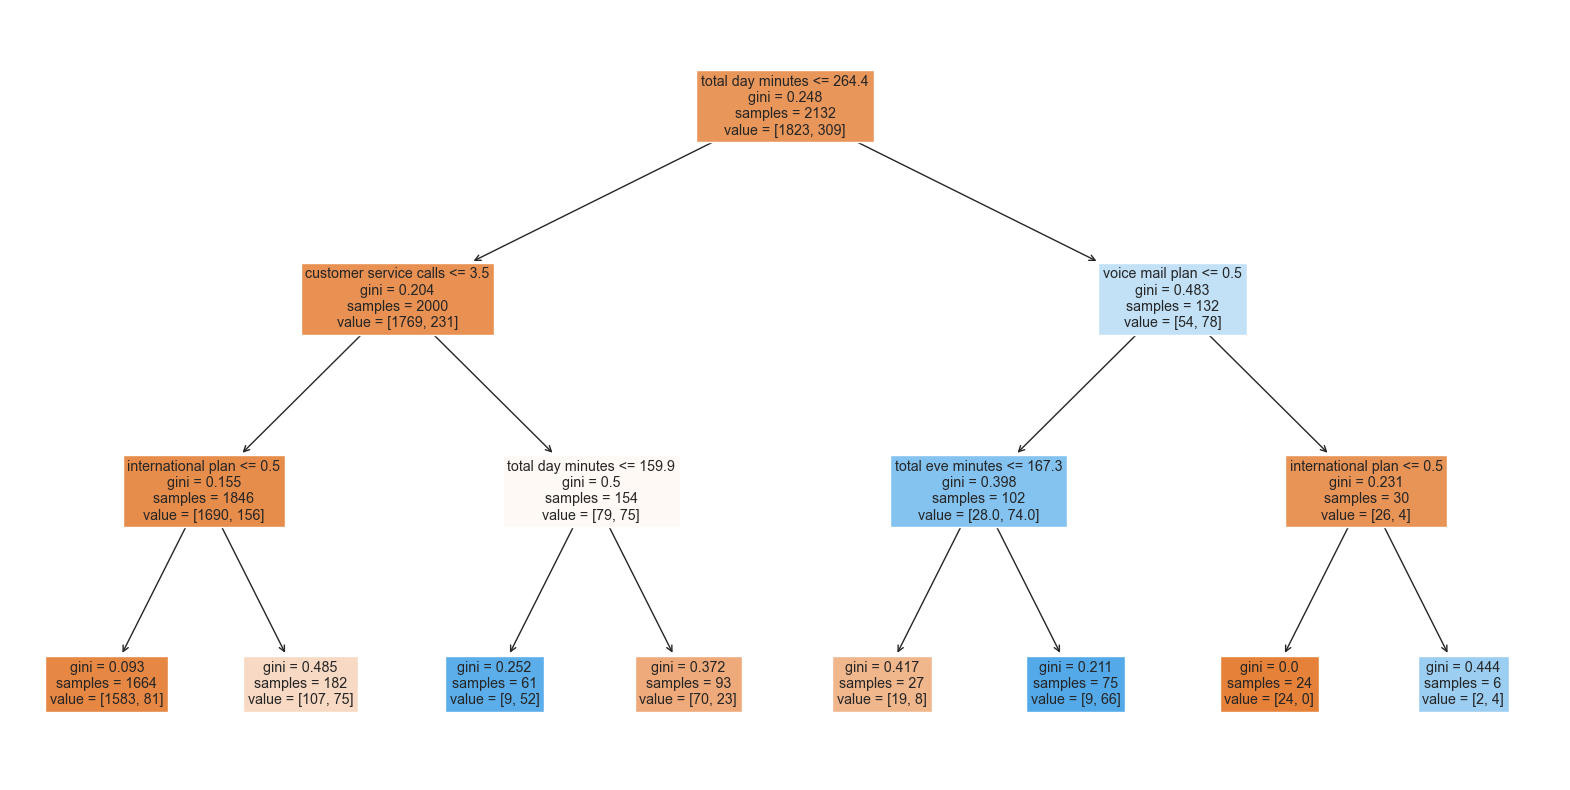

In [43]:
from sklearn.tree import DecisionTreeClassifier

# Train a surrogate decision tree on the predictions of the Random Forest model
y_train_pred = rf.predict(X_train)  # Predictions from the Random Forest
surrogate_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate_tree.fit(X_train, y_train_pred)

# Plot the surrogate decision tree
from sklearn import tree
plt.figure(figsize=(20,10))
tree.plot_tree(surrogate_tree, feature_names=X_train.columns, filled=True)
plt.show()


In [44]:
from sklearn.metrics import accuracy_score

# LOCO explanation: check how accuracy changes by dropping one feature at a time
loco_results = {}
for feature in X_train.columns:
    X_train_loco = X_train.drop(columns=[feature])
    X_test_loco = X_test.drop(columns=[feature])
    
    rf_loco = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_loco.fit(X_train_loco, y_train)
    
    y_pred_loco = rf_loco.predict(X_test_loco)
    loco_results[feature] = accuracy_score(y_test, y_pred_loco)

# Sort the results to find the most important features
sorted_loco_results = sorted(loco_results.items(), key=lambda x: x[1], reverse=True)
print("LOCO Feature Importance:", sorted_loco_results)


LOCO Feature Importance: [('total intl charge', 0.9550561797752809), ('account length', 0.9531835205992509), ('number vmail messages', 0.9531835205992509), ('total day calls', 0.9531835205992509), ('area code', 0.951310861423221), ('total night minutes', 0.951310861423221), ('state', 0.949438202247191), ('total night calls', 0.949438202247191), ('total eve calls', 0.947565543071161), ('total night charge', 0.947565543071161), ('voice mail plan', 0.9456928838951311), ('total eve minutes', 0.9456928838951311), ('total intl minutes', 0.9456928838951311), ('total day minutes', 0.9419475655430711), ('total eve charge', 0.9419475655430711), ('total day charge', 0.9400749063670412), ('total intl calls', 0.9382022471910112), ('international plan', 0.9269662921348315), ('customer service calls', 0.9119850187265918)]


In [46]:
# Get the top 3 features (replace with actual top features from SHAP or LOCO)
top_3_features = [feature for feature, _ in sorted_loco_results[:3]]
print(top_3_features)

# Retrain the Random Forest using only the top 3 features
X_train_top3 = X_train[top_3_features]
X_test_top3 = X_test[top_3_features]

rf_top3 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top3.fit(X_train_top3, y_train)

# Evaluate the new model
y_pred_top3 = rf_top3.predict(X_test_top3)
accuracy_top3 = accuracy_score(y_test, y_pred_top3)
print(f"Accuracy with Top 3 Features: {accuracy_top3}")


['total intl charge', 'account length', 'number vmail messages']
Accuracy with Top 3 Features: 0.8014981273408239


In [47]:
import pickle

# Save the trained RandomForest model with top 3 features to a .pkl file
with open('data1_model.pkl', 'wb') as file:
    pickle.dump(rf_top3, file)

print("data1_model.pkl")


data1_model.pkl


In [51]:
# Load the saved model
with open(r"C:\Users\MadhavaRaj\Desktop\churn_prediction\notebooks\data1_model.pkl", 'rb') as file:
    loaded_model = pickle.load(file)

# Example new user input for prediction (must include only the top 3 features)
new_user_input = pd.DataFrame({
    'total intl charge': [3.70],  # Example value
    'account length': [180],  # Example value
    'number vmail messages': [56]   # Example value
})

# Predict with the loaded model
new_user_prediction = loaded_model.predict(new_user_input)
print(f"Prediction for new user input: {new_user_prediction[0]}")


Prediction for new user input: 1


Dataset 2 - internet_service_churn

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace 'your_dataset.csv' with actual path)
data = pd.read_csv("C:/Users/MadhavaRaj/Desktop/churn_prediction/data/internet_service_churn.csv")

# Display first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Descriptive statistics
print(data.describe())




   id  is_tv_subscriber  is_movie_package_subscriber  subscription_age  \
0  15                 1                            0             11.95   
1  18                 0                            0              8.22   
2  23                 1                            0              8.91   
3  27                 0                            0              6.87   
4  34                 0                            0              6.39   

   bill_avg  reamining_contract  service_failure_count  download_avg  \
0        25                0.14                      0           8.4   
1         0                 NaN                      0           0.0   
2        16                0.00                      0          13.7   
3        21                 NaN                      1           0.0   
4         0                 NaN                      0           0.0   

   upload_avg  download_over_limit  churn  
0         2.3                    0      0  
1         0.0                    0

In [54]:
# Handle missing values (fill with 0 or mean for numeric columns)
data.fillna(0, inplace=True)

# Features and target
X = data.drop(['id', 'churn'], axis=1)  # Drop unnecessary columns
y = data['churn']  # Target column (churn)

# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling (if needed)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [55]:
from sklearn.ensemble import RandomForestClassifier

# Train the RandomForest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf.predict(X_test_scaled)

# Evaluate accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Classification Report: \n{class_report}")


Accuracy: 0.9419821980353272
Confusion Matrix: 
[[ 9273   522]
 [  736 11152]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      9795
           1       0.96      0.94      0.95     11888

    accuracy                           0.94     21683
   macro avg       0.94      0.94      0.94     21683
weighted avg       0.94      0.94      0.94     21683



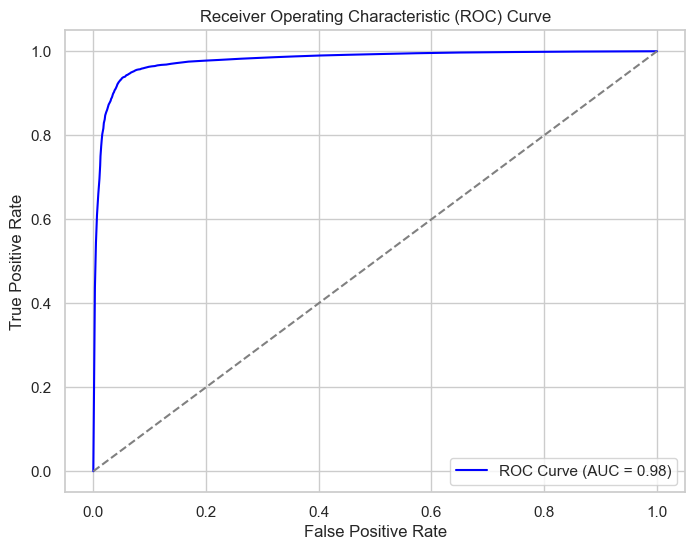

AUC: 0.9790568747135937


In [56]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get the predicted probabilities
y_pred_proba = rf.predict_proba(X_test_scaled)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

print(f"AUC: {auc}")


In [57]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns, class_names=['No Churn', 'Churn'], mode='classification')

# Explain a single instance (e.g., first row in X_test)
instance_index = 0
exp = lime_explainer.explain_instance(X_test_scaled[instance_index], rf.predict_proba)
exp.show_in_notebook(show_table=True)


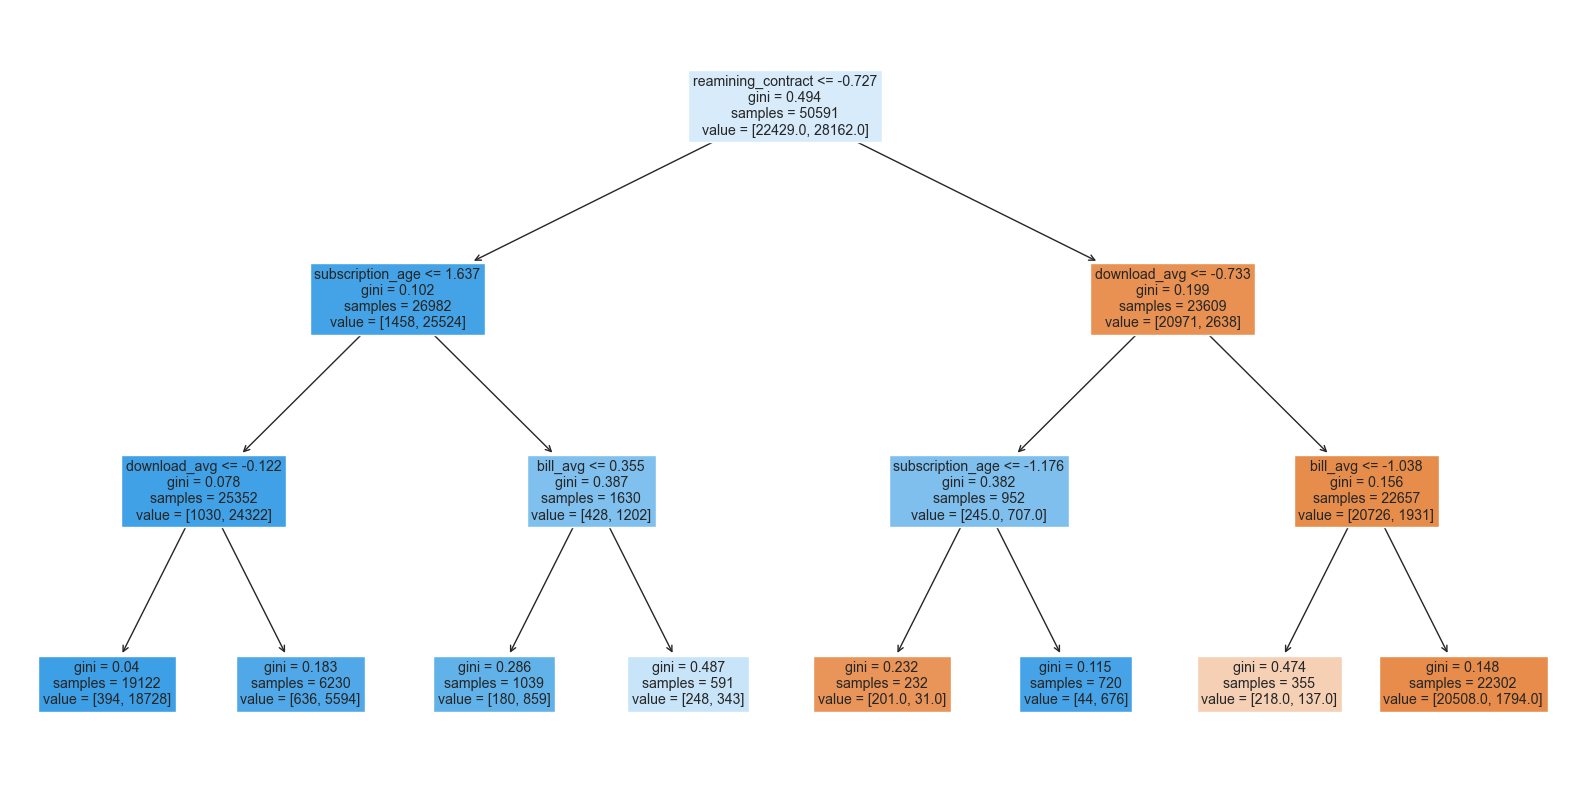

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Train a surrogate decision tree
y_train_pred = rf.predict(X_train_scaled)  # Predictions from the Random Forest
surrogate_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate_tree.fit(X_train_scaled, y_train_pred)

# Plot the surrogate decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(surrogate_tree, feature_names=X.columns, filled=True)
plt.show()


In [59]:
from sklearn.metrics import accuracy_score

# LOCO explanation: check how accuracy changes by dropping one feature at a time
loco_results = {}
for feature in X_train.columns:
    X_train_loco = X_train.drop(columns=[feature])
    X_test_loco = X_test.drop(columns=[feature])
    
    rf_loco = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_loco.fit(X_train_loco, y_train)
    
    y_pred_loco = rf_loco.predict(X_test_loco)
    loco_results[feature] = accuracy_score(y_test, y_pred_loco)

# Sort the results to find the most important features
sorted_loco_results = sorted(loco_results.items(), key=lambda x: x[1], reverse=True)
print("LOCO Feature Importance:", sorted_loco_results)

LOCO Feature Importance: [('download_avg', 0.9417516026380114), ('service_failure_count', 0.9415210072406954), ('upload_avg', 0.9411981736844532), ('download_over_limit', 0.9404602684130424), ('is_tv_subscriber', 0.9401835539362634), ('is_movie_package_subscriber', 0.9401835539362634), ('subscription_age', 0.9371858137711572), ('bill_avg', 0.9334962874141032), ('reamining_contract', 0.8120186321081031)]


In [60]:
# Get the top 3 features (replace with actual top features from SHAP or LOCO)
top_3_features = [feature for feature, _ in sorted_loco_results[:3]]
print(top_3_features)

# Retrain the Random Forest using only the top 3 features
X_train_top3 = X_train[top_3_features]
X_test_top3 = X_test[top_3_features]

rf_top3 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top3.fit(X_train_top3, y_train)

# Evaluate the new model
y_pred_top3 = rf_top3.predict(X_test_top3)
accuracy_top3 = accuracy_score(y_test, y_pred_top3)
print(f"Accuracy with Top 3 Features: {accuracy_top3}")


['download_avg', 'service_failure_count', 'upload_avg']
Accuracy with Top 3 Features: 0.6550754046949223


In [61]:
import pickle

# Save the trained RandomForest model with top 3 features to a .pkl file
with open('data12_model.pkl', 'wb') as file:
    pickle.dump(rf_top3, file)

print("data2_model.pkl")

data2_model.pkl
